In [1]:
'''
    Use centroids to build polygons: 
        I: voronoi tesselations
        II: delaunay triangulation
        III: convex hull approximation 
'''
%matplotlib inline

import pandas as pd
import numpy as np
import json 
import geojson
import matplotlib.pyplot as plt 

from pprint import pprint 

import pytess
from shapely.geometry import shape, Point
from descartes import PolygonPatch
import fiona 

from shapely import geometry
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Polygon, mapping
from scipy.spatial import Voronoi, voronoi_plot_2d

In [2]:
# define functions for analysis
def getCoords(r): 
    return (Point(r[0]), Polygon(r[1]))

In [3]:
# load geojson file for plotting
with open("../data/beijing.geojson") as json_file:
    json_data = geojson.load(json_file)

# load centroids from SOM clustering
cntr_18_22_100e = pd.read_csv('../data/centroids-18-22-som-100e.csv')

# load social media data for ROI
df_weibo = pd.read_csv('../data/inLabelRegionPoints.csv')


In [4]:
# get corners of ROI to specify plotting window
maxLon, minLon = np.max(df_weibo['lon']), np.min(df_weibo['lon'])
maxLat, minLat = np.max(df_weibo['lat']), np.min(df_weibo['lat'])
corners = [(minLon, maxLat), (maxLon, maxLat), (maxLon, minLat), (minLon, minLat)]
dfCorners = pd.DataFrame(corners)
dfCorners.columns = ['lon', 'lat']


In [5]:
# subset data and perform voronoi tesselation to generate polygons
subset = cntr_18_22_100e[['lon', 'lat']]
points = [tuple(x) for x in subset.values]
vPolys = pytess.voronoi(points)
polygons_with_centroids = [i for i in vPolys if i[0] != None]

polygons = [getCoords(i) for i in polygons_with_centroids]
dfPolygon = pd.DataFrame(polygons) 

dfPolygon.columns = ['center', 'polygon']
dfPolygon.reset_index(inplace=True)
dfPolygon.columns = ['polygonID', 'center', 'polygon']


In [6]:
dfPolygon.head()

,polygonID,center,polygon
0,0,POINT (116.6468414808125 39.89149038949022),"POLYGON ((116.6573573865473 39.88455400464395,..."
1,1,POINT (116.6744348167464 39.73903835703099),"POLYGON ((116.6442740045467 39.49962180344291,..."
2,2,POINT (116.648804131692 39.87530524583325),"POLYGON ((116.6573501609673 39.83619167383567,..."
3,3,POINT (116.6177617651295 39.83021965191913),"POLYGON ((116.6410993279208 39.78152193641412,..."
4,4,POINT (116.5475590345544 39.90418252282571),"POLYGON ((116.5628441458064 39.88688759924733,..."


In [7]:
# define schema and write polygons to shapefile for aggregation
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int', 
                    'center_lon' : 'float', 
                    'center_lat' : 'float'},
}


shape_path = '../data/18_22_100e_som_voronoi/18_22_100e_som_voronoi.shp'
with fiona.open(shape_path, 'w', 'ESRI Shapefile', schema) as c:
   for i in range(len(dfPolygon)): 
        r = dfPolygon.iloc[i]
        c.write({
            'geometry': mapping(r['polygon']),
            'properties': { 'id': i,
                            'center_lon': r['center'].coords.xy[0][0], 
                            'center_lat': r['center'].coords.xy[1][0]},
        })

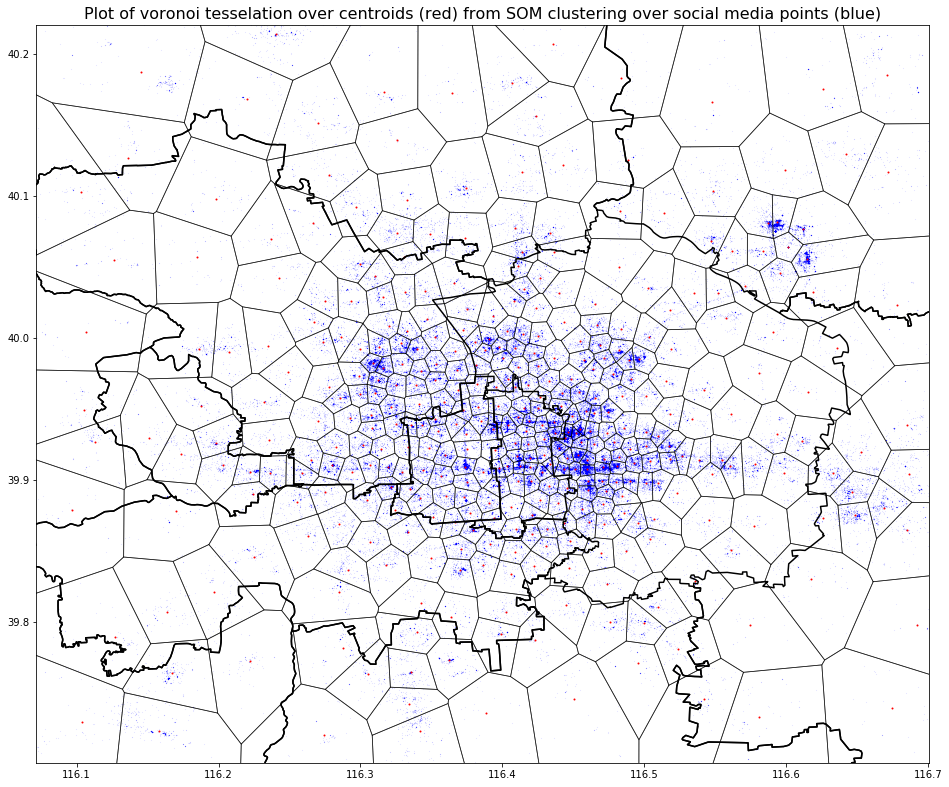

In [14]:
# plot geojson region of beijing
fig = plt.figure(figsize=(16,16))
feats = json_data['features']
for i in range(0, len(feats)): 
    try: 
        test = feats[i]
        poly = test['geometry']
        coords = poly['coordinates']
        x = [i for i,j in coords[0]]
        y = [j for i,j in coords[0]]
        ax = fig.gca() 
        ax.plot(x, y, color='black')
        ax.axis('scaled')
    except: 
        continue

# plot polygons from voronoi tesselation
ids = dfPolygon.polygonID.unique()
for i in range(len(polygons_with_centroids)): 
    if i in ids: 
        verts = polygons_with_centroids[i][1]
        pList = [Point(i) for i in verts]
        poly = geometry.Polygon([[p.x, p.y] for p in pList])
        x,y = poly.exterior.xy
        ax.plot(x, y, color='black', alpha=0.7,# color='#6699cc', alpha=0.7,
            linewidth=0.75, solid_capstyle='round', zorder=2)
    else: 
        continue

# plot scatter of social media points over polygons
ax.scatter(df_weibo['lon'], df_weibo['lat'], color='blue', s=0.001)

# plot centroids used to generate polygons
ax.scatter(cntr_18_22_100e['lon'], cntr_18_22_100e['lat'], color='red', s=1)

# limit axes to corner points of ROI
ax.set_xlim(minLon, maxLon)
ax.set_ylim(minLat, maxLat)

# reveal plot
plt.title('Plot of voronoi tesselation over centroids (red) from SOM clustering over social media points (blue)',
         fontsize=16)
plt.show()  